# Diabetic patients readmission rates preditction


In [125]:
# !pip install tqdm
# !pip install learn2learn
# !pip install tensorflow
# !pip install umap-learn

In [221]:
# Importing package
#Standard Python libraries for data and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import seaborn as sns

#sklearn packages for machine learning
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

#pytorch packages for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

%matplotlib inline


# Project introduction

- Overview: <br>
This project is focusing on developing a predictive model to ascertain the likelihood of readmission for diabetes patients.
<br>

- Target:<br>
The main goal of this project is developing a powerful machine learning model which can predict the readmission rate of patient 

# Data loading
The following cells are used to load training and testing data for our prediction

In [222]:
train_data = pd.read_csv("Dataset/diabetic_data_training.csv")
test_data = pd.read_csv("Dataset/diabetic_data_test.csv")
pd.set_option('display.max_columns', None)

In [128]:
# Function to handle different data types for plotting
def plot_column(ax, column, df):
    if df[column].dtype == 'object':
        # Check if binary
        if df[column].nunique() == 2:
            # Binary data visualization
            df[column].value_counts().plot(kind='bar', ax=ax)
        else:
            # Categorical data visualization
            df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    elif df[column].dtype == 'int64' or df[column].dtype == 'float64':
        # Numeric data visualization
        df[column].plot(kind='hist', bins=20, ax=ax)
    else:
        ax.text(0.5, 0.5, f"Unhandled data type for column: {column}", 
                fontsize=12, ha='center')
    ax.set_title(column)



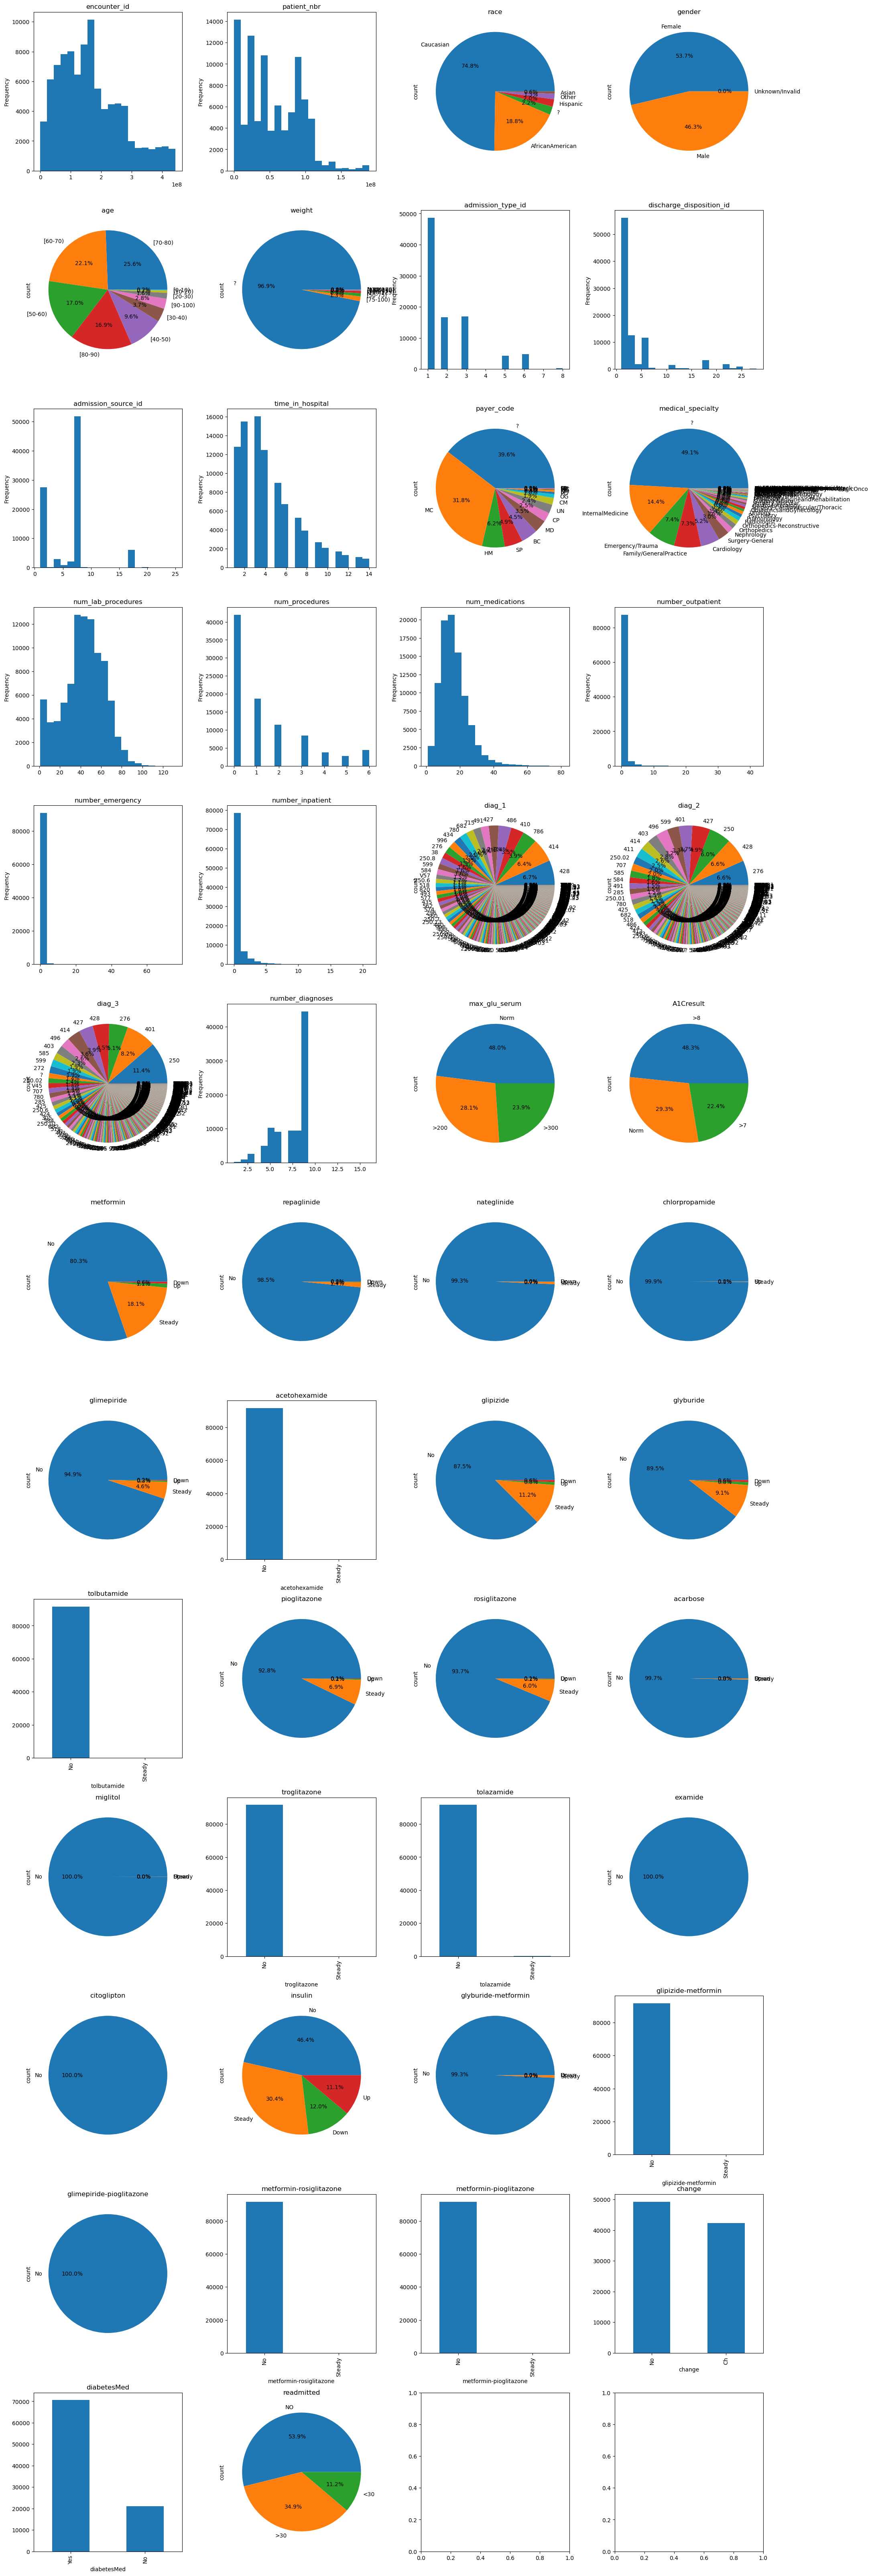

In [129]:
# fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(20, 65))
# fig.tight_layout(pad=5.0)


# for i, col in enumerate(train_data.columns):

#     plot_column(axes[i//4, i%4], col,train_data)


# plt.show()

# Data preprocessing
The following cells are used to preprocess the training and testing data. There are two main goals in our preprocessing data section of the code
- Change the string type data in our dataset to integer type data 
- Apply some applicable method to full up the missing value

In [344]:
# this part is used to change all string type data to integer type
# for the missing value, we will skip and process it at next step

df = train_data.copy()
df_test = test_data.copy()

One-Hot Encoding For race:
cons: One-hot encoding can lead to a significant increase in the dataset's dimensionality (a problem known as the "curse of dimensionality"), especially if the categorical feature has many unique values. This can increase the computational cost and may require more data to achieve good performance.
Dems Redct Would be apply, so it doesn't matter
pros: Map to a fix number implies an ordinal relationship between the categories which may not exist, but is ideal for non-ordinal categorical data. It's suitable for many machine learning models, especially those that assume no ordinal relationship between categories

Race Process
1. Remove missing since race is proved to be a significant impact to medical result.
2. One-hot encode race

In [345]:
def race_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    race_mask = (df['race'] != "?")
    df = df[race_mask]
    return df

In [346]:
df = race_filter(df)
df_encoded = pd.get_dummies(df, columns=["race"], prefix="race",dtype=int)

df_test = race_filter(df_test)
df_test_encoded = pd.get_dummies(df_test, columns=["race"], prefix="race",dtype=int)

Gender Process

1. Remove Unknown/Invalid and missing
2. One hot encode Gender

In [347]:
def gender_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    gender_mask = (df['gender'] != "Unknown/Invalid")
    df = df[gender_mask]
    return df

In [348]:
df_encoded = gender_filter(df_encoded)
df_test_encoded = gender_filter(df_test_encoded)
gender_mapping = {'Male':0,'Female':1}
df_encoded['gender'] = df_encoded['gender'].map(gender_mapping)
df_test_encoded['gender'] = df_test_encoded['gender'].map(gender_mapping)

encounter_id and patient_nbr Process 
1. n/a
2. Drop since it provide no info to the result

In [349]:
df_encoded.drop(columns=['encounter_id','patient_nbr'], inplace=True)
df_test_encoded.drop(columns=['encounter_id','patient_nbr'],inplace=True)

Age Process
1. n/a
2. Map age from range to mean

In [350]:
def age_processing(df):
    return (df.str.extract(r'(\d+)-(\d+)')[0].astype(int)+df.str.extract(r'(\d+)-(\d+)')[1].astype(int))//2

In [351]:
df_encoded['age'] = age_processing(df_encoded['age'])
df_test_encoded['age'] = age_processing(df_test_encoded['age'])

In [352]:
df_encoded['age'].value_counts()

age
75    22921
65    19751
55    15205
85    15100
45     8570
35     3329
95     2467
25     1426
15      616
5       144
Name: count, dtype: int64

Weight Process
1. Drop Weight for too many missing values and no information to predict.
2. n/a

In [353]:
df_encoded.drop(columns=['weight'], inplace=True)
df_test_encoded.drop(columns=['weight'], inplace=True)

num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient No need to be encode since no missing and integer.

diag_1,diag_2 and diag_3 Process:

Filte diag_1, diag_2 and diag_3 by number_diagnoses. If the amount of diagnoses in diag_1, diag_2 and diag_3 doesn't match the number_diagnoses, then remove.
Layer encoding diags according to the ICD-9 Code Category, drop original 3 diag

In [354]:
def diag_missing_value_filter(df):

    df['number_diagnoses'] = pd.to_numeric(df['number_diagnoses'], errors='coerce')
    mask = ((df['number_diagnoses'] <= 3) & (
            (3 - df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) >= df['number_diagnoses'])) | (
    (df['number_diagnoses'] > 3) & (df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) == 0) 
    df_filtered = df[mask].copy()

    return df_filtered

def diag_layer_encoding(df):

    # Define the encoding function
    def encode_element(element):
        encoding_result = [0] * 20  # Default encoding

        if pd.notna(element):
            if element[0].isdigit():
                element = float(element)
                # Encode based on numeric range
                if 1 <= element <= 139:
                    encoding_result[0] = 1
                elif 140 <= element <= 239:
                    encoding_result[1] = 1
                elif 240 <= element <= 279:
                    encoding_result[2] = 1
                elif 280 <= element <= 289:
                    encoding_result[3] = 1
                elif 290 <= element <= 319:
                    encoding_result[4] = 1
                elif 320 <= element <= 389:
                    encoding_result[5] = 1
                elif 390 <= element <= 459:
                    encoding_result[6] = 1
                elif 460 <= element <= 519:
                    encoding_result[7] = 1
                elif 520 <= element <= 579:
                    encoding_result[8] = 1
                elif 580 <= element <= 629:
                    encoding_result[9] = 1
                elif 630 <= element <= 679:
                    encoding_result[10] = 1
                elif 680 <= element <= 709:
                    encoding_result[11] = 1
                elif 710 <= element <= 739:
                    encoding_result[12] = 1
                elif 740 <= element <= 759:
                    encoding_result[13] = 1
                elif 760 <= element <= 779:
                    encoding_result[14] = 1
                elif 780 <= element <= 799:
                    encoding_result[15] = 1
                elif 800 <= element <= 999:
                    encoding_result[16] = 1
                # Add more conditions for other ranges if needed
            elif element[0].isalpha():
                # Encode based on string prefix
                if element.startswith('E'):
                    encoding_result[17] = 1
                elif element.startswith('V'):
                    encoding_result[18] = 1
                elif element.startswith('M'):
                    encoding_result[19] = 1
                # Add more conditions for other prefixes if needed

        return encoding_result

    for i in range(1,4):
        encoded_columns = df["diag_"+str(i)].apply(encode_element)

    # Create new columns with "diag_1" as a prefix
        for j in range(20):
            new_column_name = "diag_" + str(i)+"_"+ str(j+1)
            df[new_column_name] = encoded_columns.apply(lambda x: x[j])

    return df


In [355]:
df_encoded = diag_missing_value_filter(df_encoded)
df_encoded = diag_layer_encoding(df_encoded)
df_test_encoded = diag_missing_value_filter(df_test_encoded)
df_test_encoded = diag_layer_encoding(df_test_encoded)

for i in range(1,4):
        df_encoded.drop(columns=[f'diag_{i}'], inplace=True)
        df_test_encoded.drop(columns=[f'diag_{i}'], inplace=True)

number_diagnoses pass since no missing and integer max_glu_serum and A1Cresult Process: 
1. n/a 
2. index map to 0-3



In [356]:
max_glu_serum_mapping = {'>200': 2, '>300': 3, 'normal': 1}
A1Cresult_mapping = {'>8':3,'>7':2,'normal':1}

In [357]:
df_encoded['max_glu_serum'] = df_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)
df_test_encoded['max_glu_serum'] = df_test_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)

df_encoded["A1Cresult"] = df_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)
df_test_encoded["A1Cresult"] = df_test_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)

metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone Process:

1. drop 'examide', 'citoglipton','glimepiride-pioglitazone' and 'metformin-rosiglitazone' since single value observed
2. index map to 0-3

In [358]:
df_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
df_test_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
medics = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
        'metformin-pioglitazone']
for i in medics:
    df_encoded.loc[df_encoded[i] == 'Up', [i]] = 3  
    df_encoded.loc[df_encoded[i] == 'Down', [i]] = 1 
    df_encoded.loc[df_encoded[i] == 'Steady', [i]] = 2 
    df_encoded.loc[df_encoded[i] == 'No', [i]] = 0
    df_test_encoded.loc[df_test_encoded[i] == 'Up', [i]] = 3  
    df_test_encoded.loc[df_test_encoded[i] == 'Down', [i]] = 1 
    df_test_encoded.loc[df_test_encoded[i] == 'Steady', [i]] = 2 
    df_test_encoded.loc[df_test_encoded[i] == 'No', [i]] = 0 
 

change and diabetesMed Process

1. n/a
2. binary map to 1/0

In [359]:
change_mapping = {'No':0,'Ch':1}
diabetesMed_mapping = {'No':0,'Yes':1}

df_encoded['change'] = df_encoded['change'].map(change_mapping)
df_encoded['diabetesMed'] = df_encoded['diabetesMed'].map(diabetesMed_mapping)

df_test_encoded['change'] = df_test_encoded['change'].map(change_mapping)
df_test_encoded['diabetesMed'] = df_test_encoded['diabetesMed'].map(diabetesMed_mapping)

readmitted Process: 
1. n/a 
2. index mapping, No as 0, >30 as 1 and <30 as most significant as 2 and drop readmitted for test

In [360]:
readmitted_mapping = {'NO':0,'>30':1,'<30':2}
df_encoded['readmitted'] = df_encoded['readmitted'].map(readmitted_mapping)
df_test_encoded['readmitted'] = df_test_encoded['readmitted'].map(readmitted_mapping)

y_readmitted = df_encoded["readmitted"]
y_test_readmitted = df_test_encoded["readmitted"]

df_encoded.drop(columns=["readmitted"],axis=1,inplace=True)
df_test_encoded.drop(columns=["readmitted"],axis=1,inplace=True)

'admission_type_id','discharge_disposition_id','admission_source_id' Process:
1. n/a
2. target encoding

In [361]:
X_train = df_encoded
Y_train = y_readmitted

features = ['admission_type_id','discharge_disposition_id','admission_source_id']

'''for name in names:
    category_means = df_encoded.groupby(name)['readmitted'].mean().reset_index()
    category_means.columns = [name,name+'_readmitted_Mean']
    df_encoded = pd.merge(df_encoded, category_means, on=name, how='left')
    df_encoded = df_encoded.drop(name, axis=1)'''


for feature in features:
    
    mean_col_name = f'{feature}_Encoded'
    means = X_train.join(Y_train).groupby(feature)['readmitted'].mean()
    df_encoded[mean_col_name] = df_encoded[feature].map(means)
    df_test_encoded[mean_col_name] = df_test_encoded[feature].map(means)

    df_encoded = df_encoded.drop(feature, axis=1)
    df_test_encoded = df_test_encoded.drop(feature, axis=1)

Payer Code Process:

1.2 RandomForestClassifier fill missing
1.3 KNN filling missing

2. index encoding payer code

In [362]:
def payer_code_index_encoding(df):
    df.loc[df['payer_code'] == 'MD', ['payer_code']] = 1
    df.loc[df['payer_code'] == 'MC', ['payer_code']] = 2
    df.loc[df['payer_code'] == 'HM', ['payer_code']] = 3
    df.loc[df['payer_code'] == 'UN', ['payer_code']] = 4
    df.loc[df['payer_code'] == 'BC', ['payer_code']] = 5
    df.loc[df['payer_code'] == 'CP', ['payer_code']] = 6
    df.loc[df['payer_code'] == 'SP', ['payer_code']] = 7
    df.loc[df['payer_code'] == 'SI', ['payer_code']] = 8
    df.loc[df['payer_code'] == 'CM', ['payer_code']] = 9
    df.loc[df['payer_code'] == 'DM', ['payer_code']] = 10
    df.loc[df['payer_code'] == 'CH', ['payer_code']] = 11
    df.loc[df['payer_code'] == 'PO', ['payer_code']] = 12
    df.loc[df['payer_code'] == 'WC', ['payer_code']] = 13
    df.loc[df['payer_code'] == 'OG', ['payer_code']] = 14
    df.loc[df['payer_code'] == 'OT', ['payer_code']] = 15
    df.loc[df['payer_code'] == 'MP', ['payer_code']] = 16
    df.loc[df['payer_code'] == 'FR', ['payer_code']] = 17
    return df

In [363]:
df_encoded = payer_code_index_encoding(df_encoded)
df_test_encoded = payer_code_index_encoding(df_test_encoded)

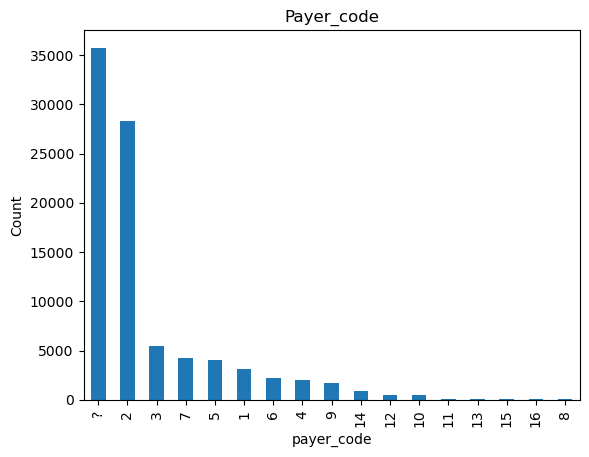

In [364]:
df_encoded['payer_code'].value_counts().plot(kind='bar')

plt.title('Payer_code')
plt.xlabel('payer_code')
plt.ylabel('Count')


plt.show()

In [365]:
#separating the columns that contain null values and need to predicted.
payer_code_col = ['payer_code']
other_cols = list(df_encoded.columns)
other_cols.remove("payer_code")
other_cols.remove("medical_specialty")

Random Forst

In [366]:
payer_code_mask = (df_encoded["payer_code"] != "?")
df_notnans = df_encoded[payer_code_mask]
X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_cols], df_notnans[payer_code_col].astype(int),
                                                    train_size=0.75,
                                                    random_state=1)

In [ ]:
rf = RandomForestClassifier()
paramsgrid  = {'n_estimators': [100,200,400],
               'max_depth': [25, 30,50,100],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 5, 10]
 }

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)
 
rf_random.fit(X_test, y_test.values.ravel())

In [ ]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 100}

In [ ]:
rf1 =(RandomForestClassifier(max_depth=100,n_estimators = 400,min_samples_leaf=1,min_samples_split=10))
rf1.fit(X_train, y_train.values.ravel())
score = rf1.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

Score is 0.5628076980456512


KNN filling

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
train_score = []
test_score = []


for i in range(6,30,2):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train.values,y_train.values.ravel())
    
    train_score.append(knn.score(X_train.values,y_train.values.ravel()))
    test_score.append(knn.score(X_test.values,y_test.values.ravel()))


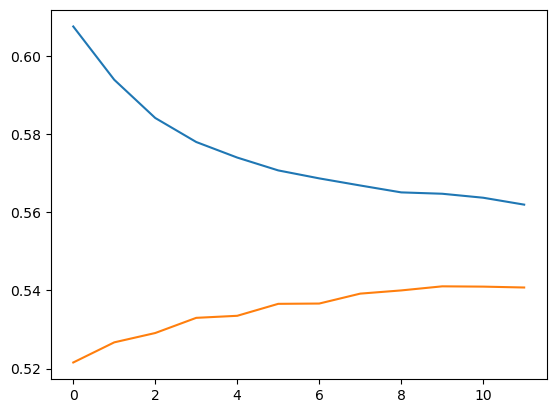

In [ ]:
plt.plot(train_score)
plt.plot(test_score)

In [ ]:
knn2 =(KNeighborsClassifier(n_neighbors= 21))
# # Fit on the train data
knn2.fit(X_train.values, y_train.values.ravel())

# # Check the prediction score
score = knn2.score(X_test.values, y_test.values.ravel())
print(f"The score on the testset is {score}")

The score on the testset is 0.539236162912129


56>54, therefore use randomforst for medical_specialty and payercode

In [368]:
payer_code_mask = (df_encoded["payer_code"] == "?")
df_notnans = df_encoded[payer_code_mask]
df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])
df_encoded.loc[payer_code_mask, 'payer_code'] = df_notnans['payer_code']


/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_1092/2230776403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])


In [369]:
test_payer_code_mask = (df_test_encoded["payer_code"] == "?")
df_notnans = df_test_encoded[test_payer_code_mask]
df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])
df_test_encoded.loc[test_payer_code_mask, 'payer_code'] = df_notnans['payer_code']


/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_1092/1322505668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])


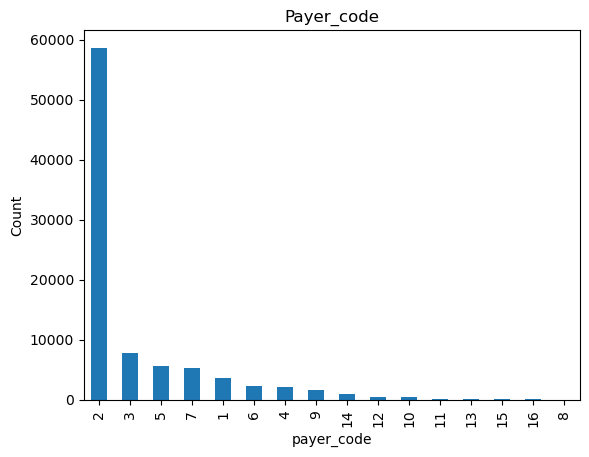

In [370]:
df_encoded['payer_code'].value_counts().plot(kind='bar')


plt.title('Payer_code')
plt.xlabel('payer_code')
plt.ylabel('Count')


plt.show()

medical_specialty Proces:
1. index encoding label
2. RF and KNN filling

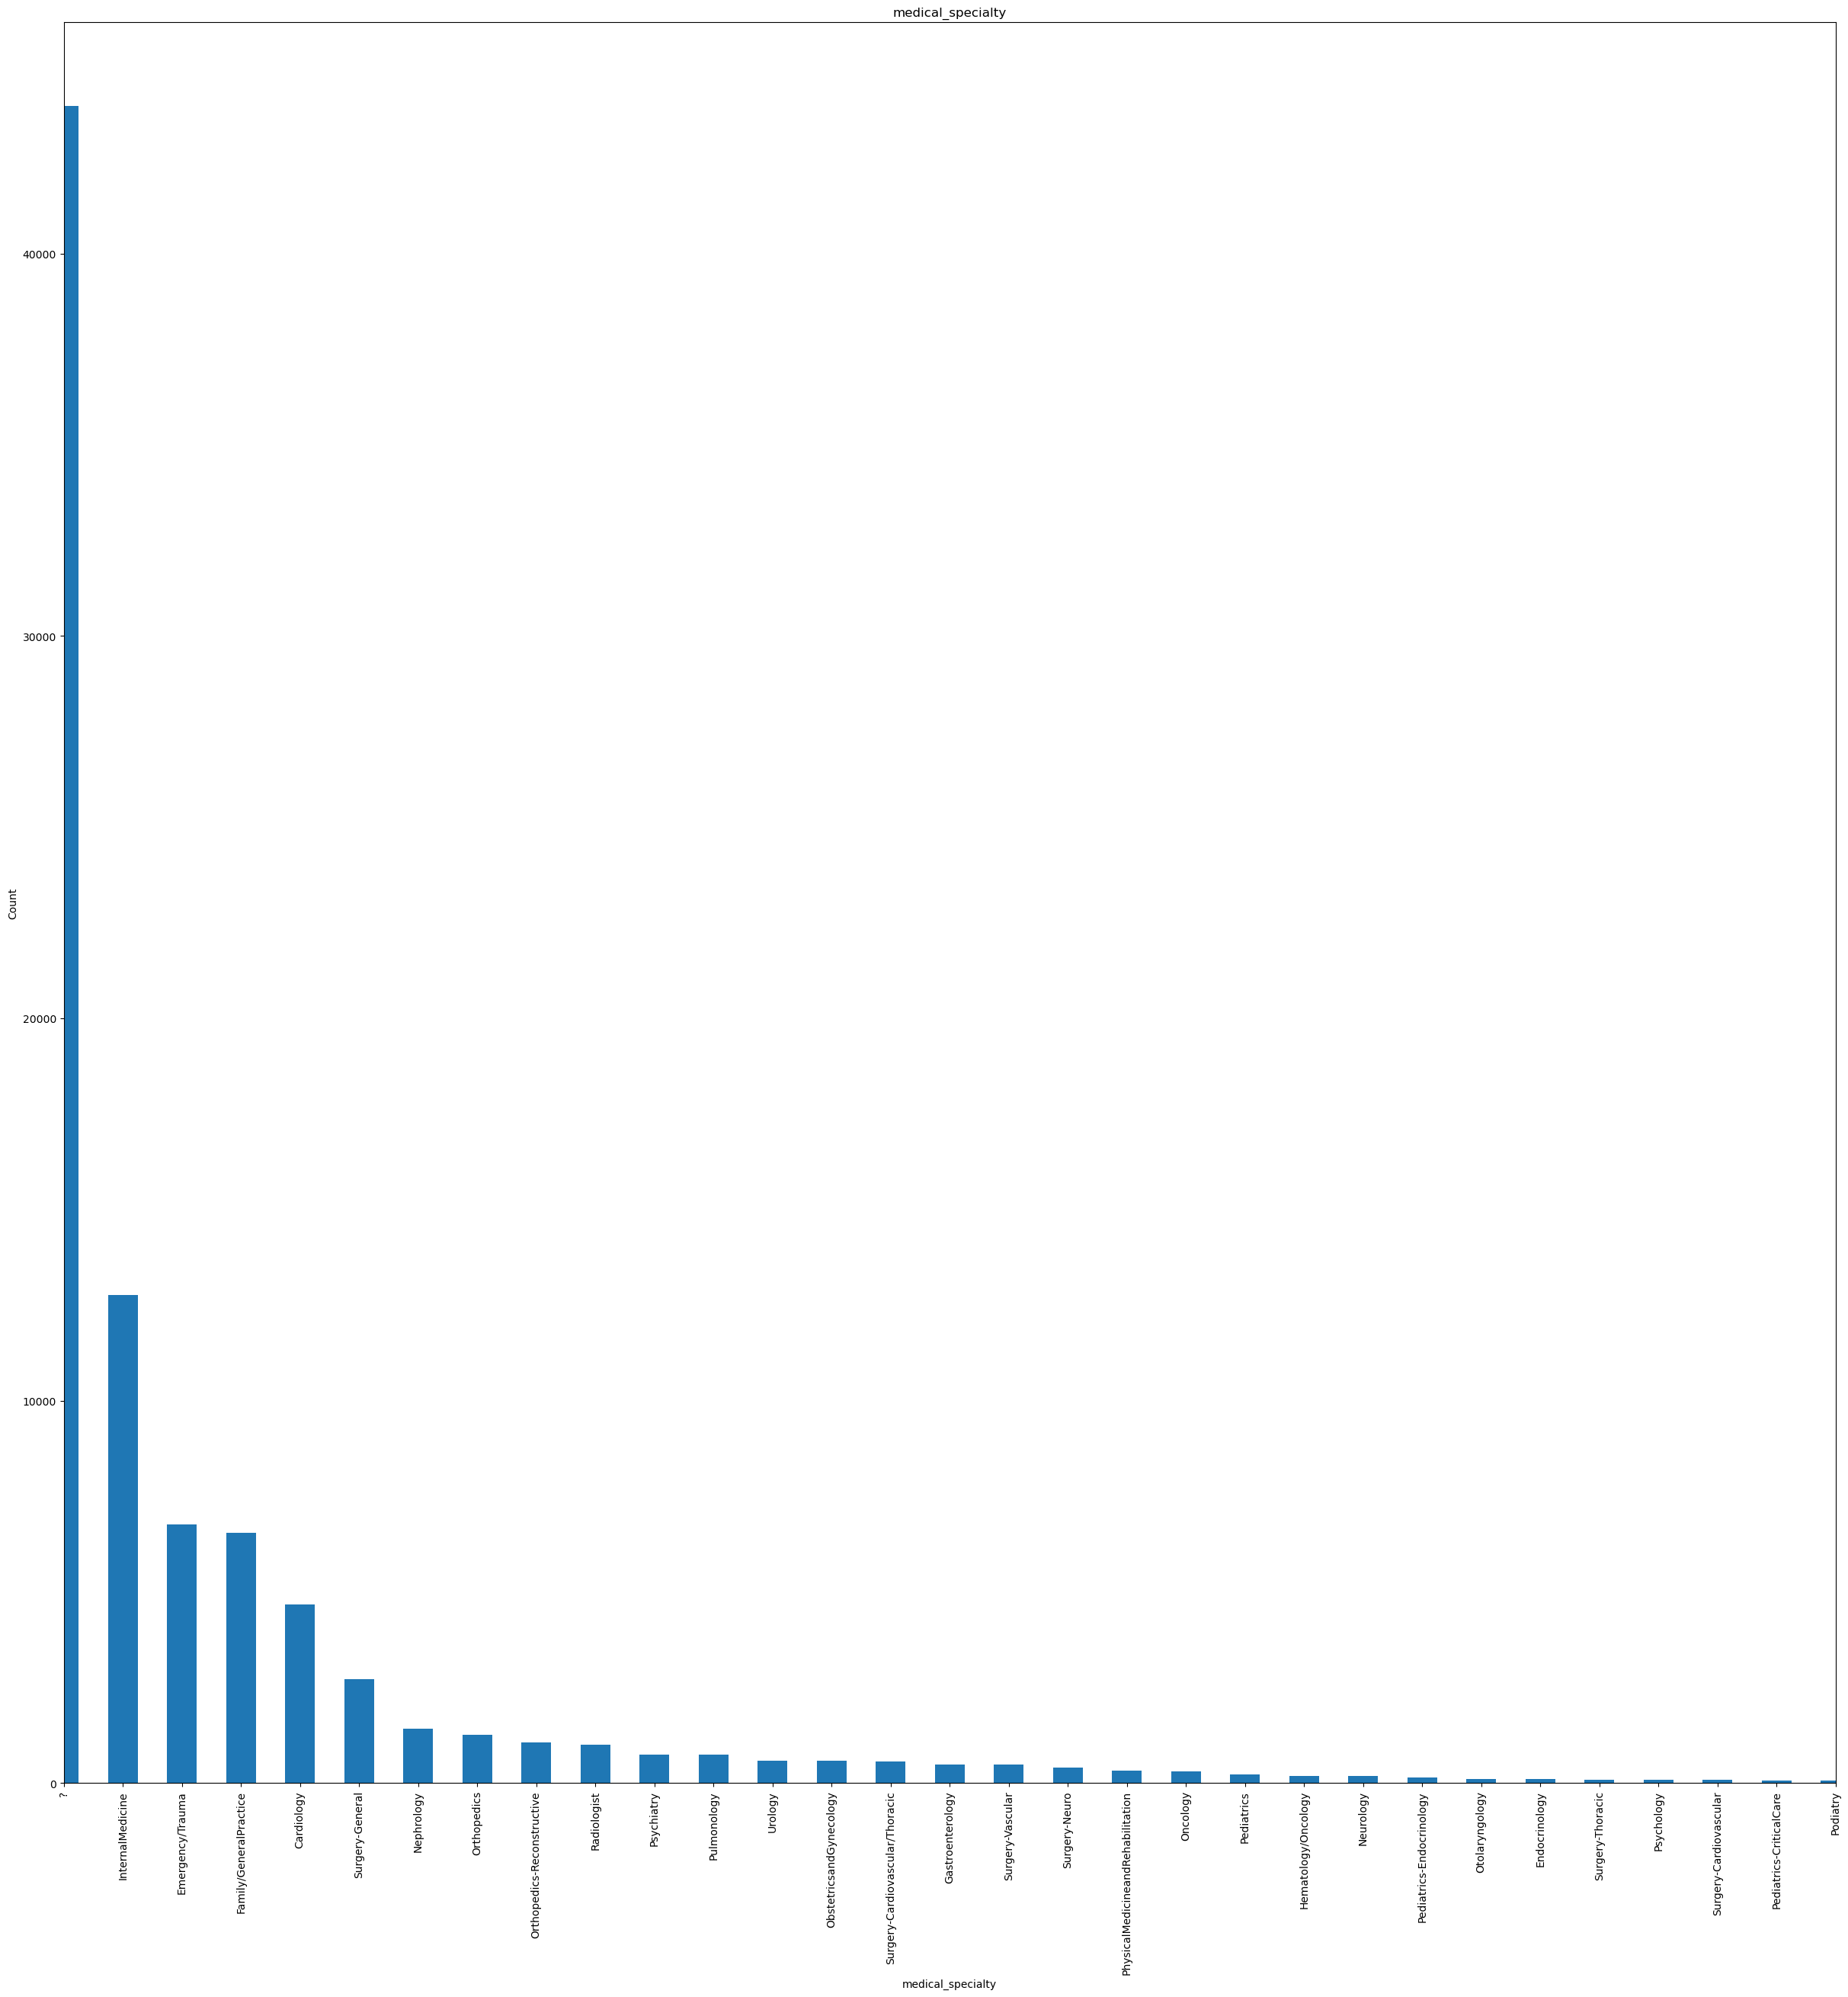

In [371]:
df_encoded['medical_specialty'].value_counts().plot(kind='bar',figsize=(30, 30))


plt.title('medical_specialty')
plt.xlabel('medical_specialty')

plt.ylabel('Count')
plt.xlim(0,30)

plt.show()

In [372]:
train_medical_specialty = df_encoded["medical_specialty"].unique()
test_medical_specialty = df_test_encoded["medical_specialty"].unique()

train_medical_specialty = list(train_medical_specialty)
train_medical_specialty.remove("?")
train_medical_specialty = set(train_medical_specialty)

test_medical_specialty = list(test_medical_specialty)
test_medical_specialty.remove("?")
test_medical_specialty = set(test_medical_specialty)

In [373]:
medical_specialty_lable = train_medical_specialty.union(test_medical_specialty)

medical_specialty_nan_mask = (df_encoded['medical_specialty'] != "?")
medical_specialty_test_nan_mask = (df_test_encoded['medical_specialty'] != "?")

medical_specialty_dict = {element: index for index, element in enumerate(medical_specialty_lable)}


medical_specialty_test_to_be_encoded = df_test_encoded[medical_specialty_test_nan_mask]
medical_specialty_test_to_be_encoded['medical_specialty']= medical_specialty_test_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])

medical_specialty_to_be_encoded = df_encoded[medical_specialty_nan_mask]
medical_specialty_to_be_encoded['medical_specialty'] = medical_specialty_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])


/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_1092/2194747546.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medical_specialty_test_to_be_encoded['medical_specialty']= medical_specialty_test_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])
/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_1092/2194747546.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medical_specialty_to_be_encoded['medical_specialty'] = medical_specialty_to_be_encoded['medical_sp

In [374]:
df_encoded['medical_specialty'] = medical_specialty_to_be_encoded['medical_specialty']
df_test_encoded['medical_specialty'] = medical_specialty_test_to_be_encoded['medical_specialty']


RF for medical_specialty

In [ ]:
medical_specialty_mask = df_encoded["medical_specialty"].notnull()
df_notnans = df_encoded[medical_specialty_mask]
X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_cols], df_notnans["medical_specialty"].astype(int),
                                                    train_size=0.75,
                                                    random_state=1)


rf = RandomForestClassifier()
paramsgrid  = {'n_estimators': [100,200,400],
               'max_depth': [25, 30,50,100],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 5, 10]
 }

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)
 
rf_random.fit(X_test, y_test.values.ravel())

"\nrf = RandomForestClassifier()\nparamsgrid  = {'n_estimators': [100,200,400],\n               'max_depth': [25, 30,50,100],\n 'min_samples_leaf': [1, 2, 3],\n 'min_samples_split': [2, 5, 10]\n }\n\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)\n \nrf_random.fit(X_test, y_test.values.ravel())"

In [ ]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 100}

In [375]:
rf1 =(RandomForestClassifier(max_depth=100,n_estimators = 400,min_samples_leaf=1,min_samples_split=10))
rf1.fit(X_train, y_train.values.ravel())
score = rf1.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

Score is 0.563329852304938


KNN for medical_specialty

In [ ]:
train_score = []
test_score = []

for i in range(5,30,2):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train.values,y_train.values.ravel())
    trianscore = knn.score(X_train.values,y_train.values.ravel())
    testscore = knn.score(X_test.values,y_test.values.ravel())
    train_score.append(trianscore)
    test_score.append(testscore)
    print(f"train score is: {trianscore}, test score is: {testscore}")

train score is: 0.4991797035214156, test score is: 0.322815960625769
train score is: 0.46926817835589146, test score is: 0.3280892951309545
train score is: 0.44846780336321557, test score is: 0.3358235190718931
train score is: 0.43402472607956877, test score is: 0.3414484092107576
train score is: 0.42397609421690985, test score is: 0.34065740903497976
train score is: 0.4163297591843909, test score is: 0.3436456319212515
train score is: 0.4099724614753618, test score is: 0.3474248549833011
train score is: 0.40677916446944395, test score is: 0.35085252241167164
train score is: 0.40191597820355074, test score is: 0.3504130778695729
train score is: 0.39790238471904843, test score is: 0.35111618913693093
train score is: 0.3938887912345462, test score is: 0.35225874494638776
train score is: 0.39104704986230737, test score is: 0.3527860783969063
train score is: 0.3883224937012949, test score is: 0.3532255229390051


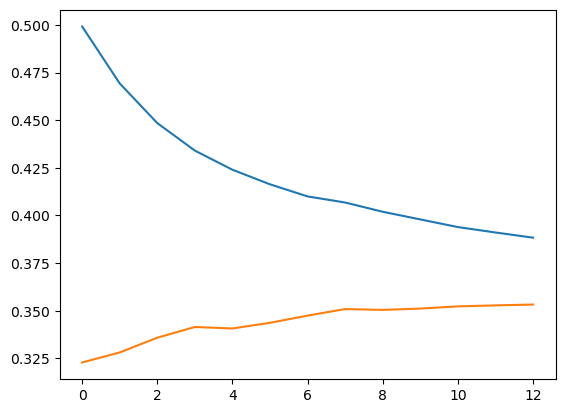

In [ ]:
plt.plot(train_score)
plt.plot(test_score)

In [ ]:
knn2 =(KNeighborsClassifier(n_neighbors= 25))
# # Fit on the train data
knn2.fit(X_train.values, y_train.values.ravel())

# # Check the prediction score
score = knn2.score(X_test.values, y_test.values.ravel())
print(f"The score on the testset is {score}")

The score on the testset is 0.35225874494638776


53>35, therefore use RF

In [376]:
medical_specialty_code_mask = df_encoded["medical_specialty"].isna()
df_notnans = df_encoded[medical_specialty_code_mask]
df_notnans["medical_specialty"] = rf1.predict(df_notnans[other_cols])
df_encoded.loc[medical_specialty_code_mask, 'medical_specialty'] = df_notnans['medical_specialty']


/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_1092/2029475354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnans["medical_specialty"] = rf1.predict(df_notnans[other_cols])


In [377]:
medical_specialty_test_code_mask = df_test_encoded["medical_specialty"].isna()
df_test_notnans = df_test_encoded[medical_specialty_test_code_mask]
df_test_notnans["medical_specialty"] = rf1.predict(df_test_notnans[other_cols])
df_test_encoded.loc[medical_specialty_test_code_mask, 'medical_specialty'] = df_test_notnans['medical_specialty']

/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_1092/2954474837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_notnans["medical_specialty"] = rf1.predict(df_test_notnans[other_cols])


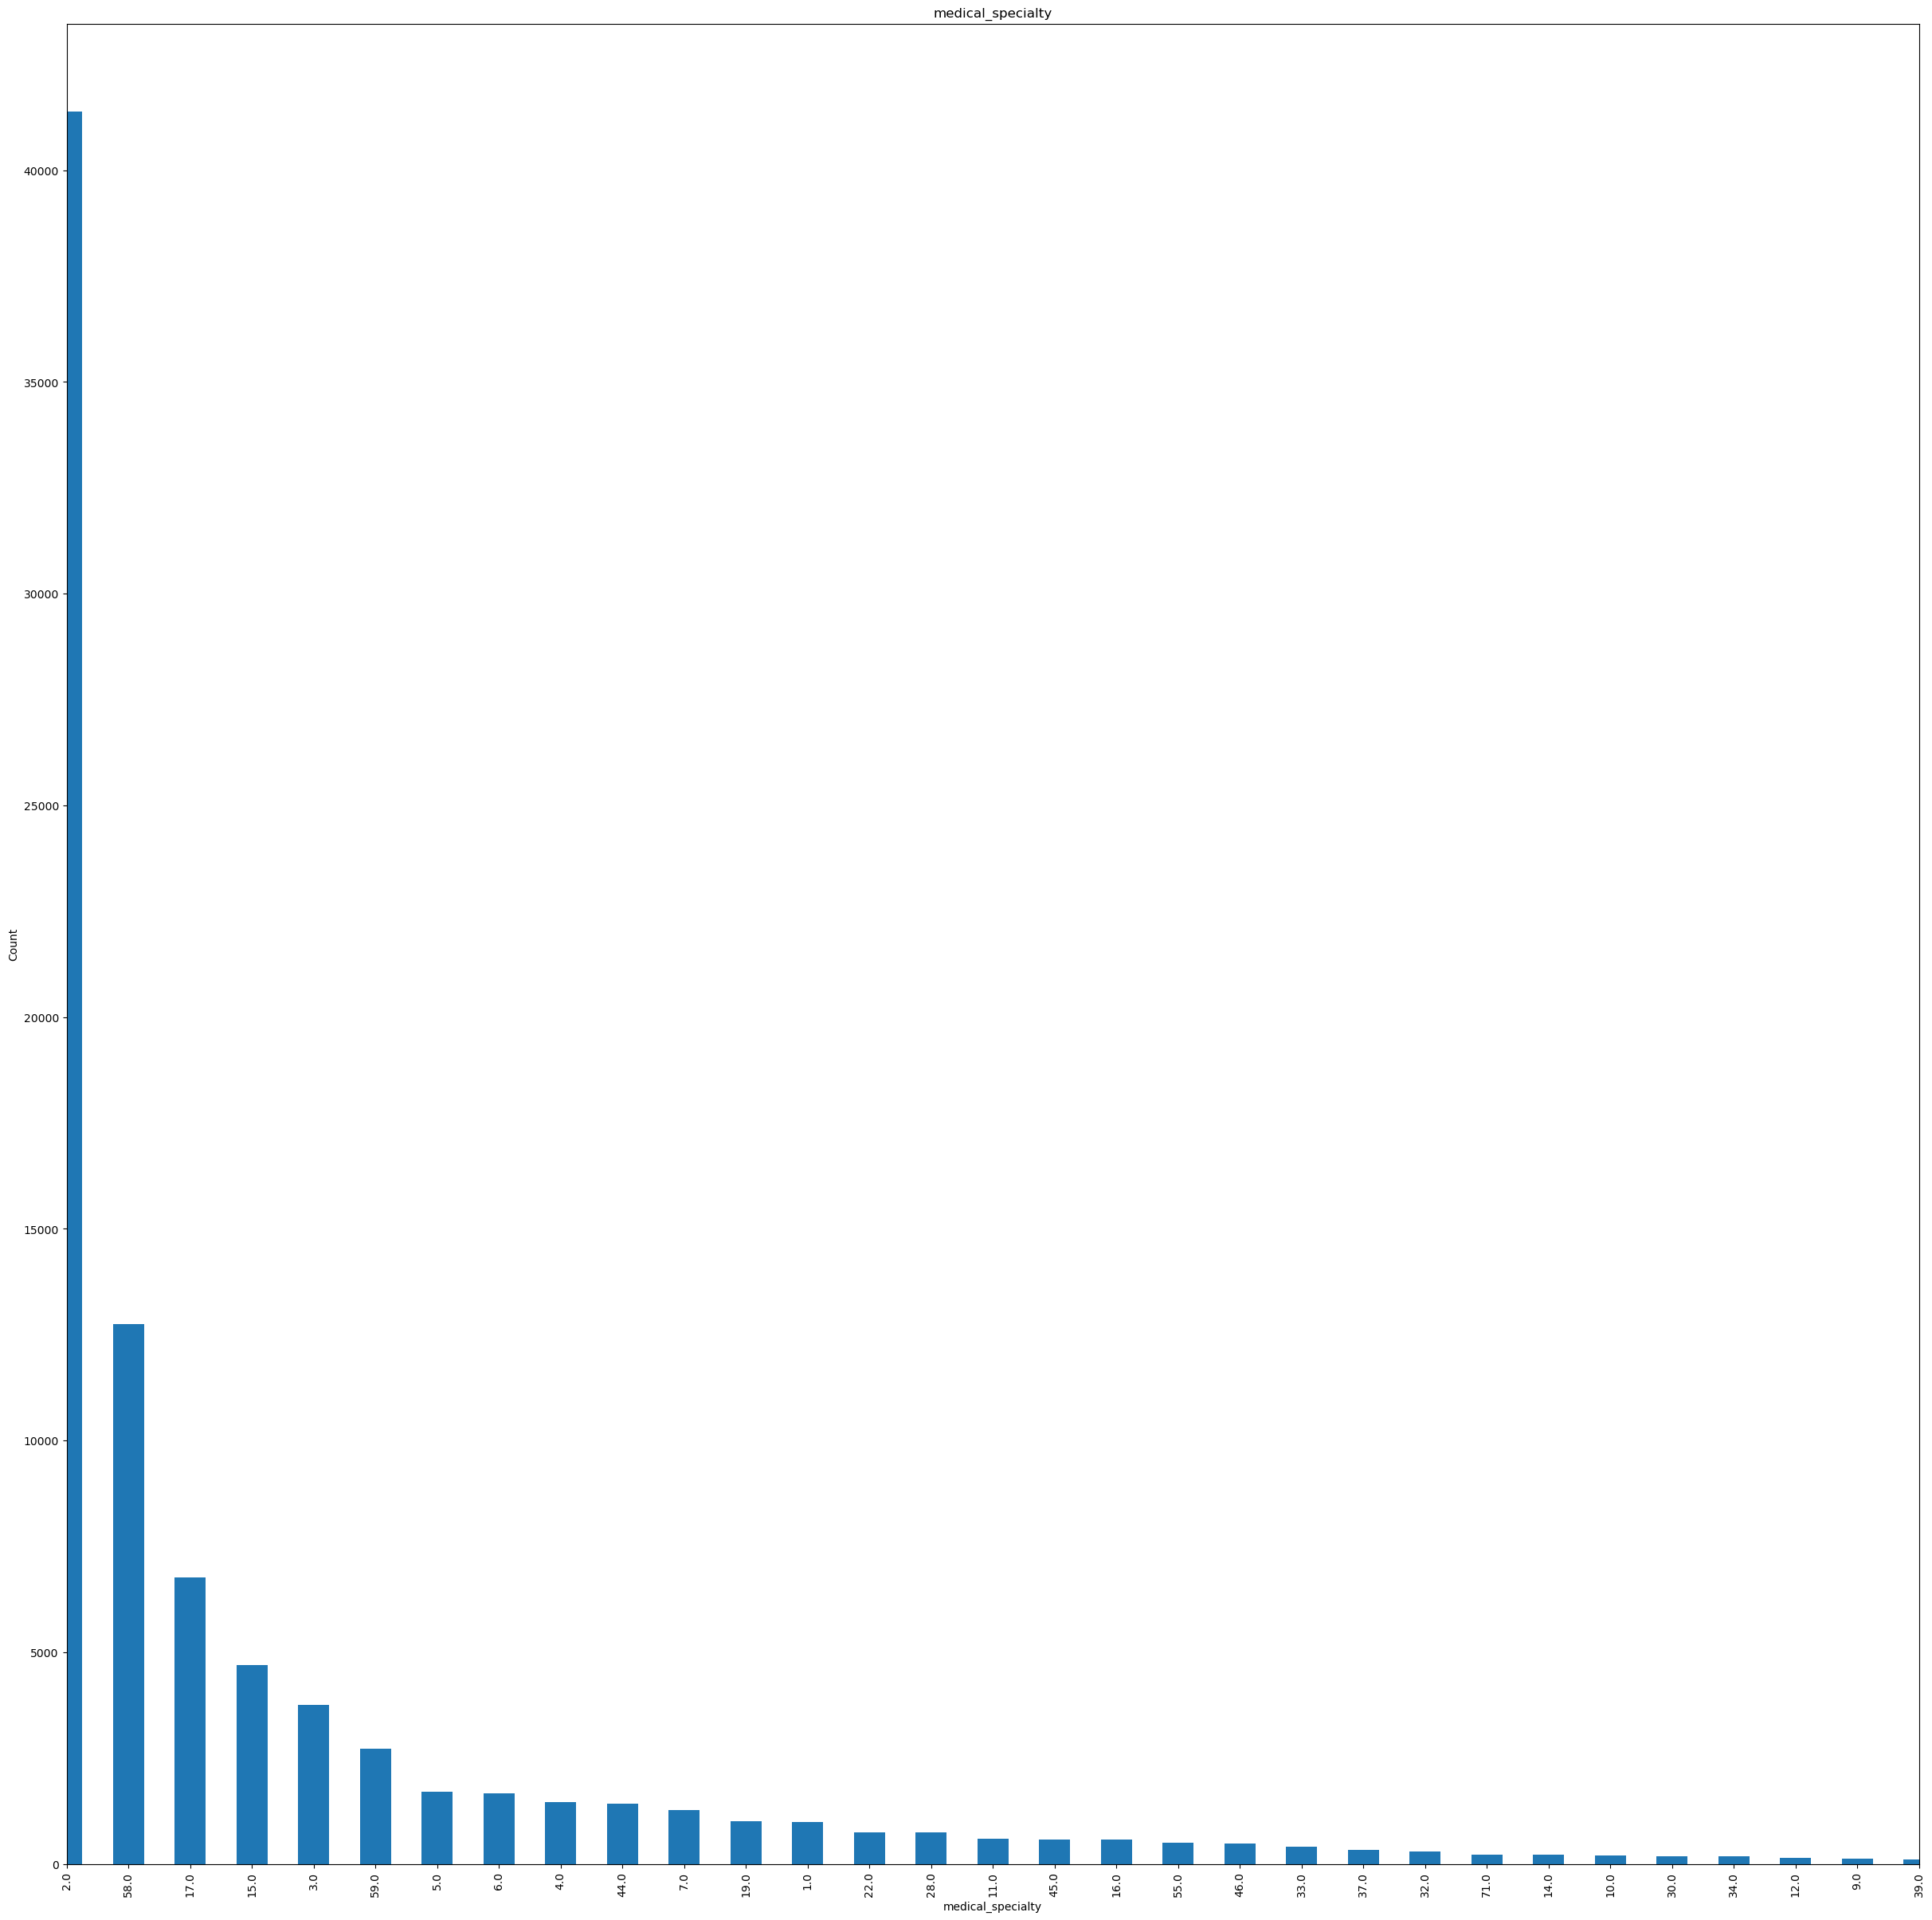

In [378]:
df_encoded['medical_specialty'].value_counts().plot(kind='bar',figsize=(30, 30))


plt.title('medical_specialty')
plt.xlabel('medical_specialty')

plt.ylabel('Count')
plt.xlim(0,30)

plt.show()

In [380]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(df_encoded,y_readmitted )

In [390]:
def random_forest_score(train, label, test, test_label):
    nb = RandomForestClassifier()
    nb.fit(train, label)
    y_nb = nb.predict(test)
    mse = np.mean((test_label - y_nb) ** 2)
    accuracy = accuracy_score(y_nb,test_label)

    return mse, accuracy

In [391]:
random_forest_score(X_res,y_res,df_test_encoded,y_test_readmitted)

(0.6111390368955464, 0.585503166783955)

In [392]:
random_forest_score(df_encoded,y_readmitted,df_test_encoded,y_test_readmitted)

(0.5989745651955364, 0.589826078214537)

### Dimension Reduction
1. Feature Selection by random forest
2. PCA/PPCA
3. LDA/QDA
4. following to T-SNE
5. Autoencoders
6. Unsupervised Algorithmn

In [ ]:
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(df_encoded, y_readmitted)

feature_importances = pd.DataFrame(clf.feature_importances_, 
                                   index = df_encoded.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
                                  
feature_importances.head(10)
Selector = SelectFromModel(clf, prefit=True, threshold='mean')
X_selected = Selector.transform(df_encoded)

selected_features = df_encoded.columns[(Selector.get_support())]

df_encoded_selected = pd.DataFrame(X_selected, columns=selected_features)
df_test_encoded_selected = df_test_encoded[selected_features]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
features_to_scale = ["age","medical_specialty","num_lab_procedures","num_medications"]

df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])
df_test_encoded[features_to_scale] = scaler.fit_transform(df_test_encoded[features_to_scale])

df_encoded_selected[features_to_scale] = scaler.fit_transform(df_encoded_selected[features_to_scale])
df_test_encoded_selected[features_to_scale] = scaler.fit_transform(df_test_encoded_selected[features_to_scale])

C:\Users\JCH\AppData\Local\Temp\ipykernel_1972\2574883089.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_encoded_selected[features_to_scale] = scaler.fit_transform(df_test_encoded_selected[features_to_scale])


In [ ]:
df_encoded.to_csv('encoded_train.csv',index=False)
df_test_encoded.to_csv('encoded_test.csv',index=False)
df_encoded_selected.to_csv('encoded_train_selected.csv',index=False)
df_test_encoded_selected.to_csv('encoded_test_selected.csv',index=False)
pd.DataFrame(y_readmitted).to_csv('y_readmitted.csv',index=False)
pd.DataFrame(y_test_readmitted).to_csv('y_test_readmitted.csv',index=False)

In [ ]:
df_encoded = pd.read_csv('encoded_train.csv')
df_test_encoded = pd.read_csv('encoded_test.csv')

In [394]:
df_encoded_selected = pd.read_csv("encoded_train_selected.csv")
df_test_encoded_selected = pd.read_csv("encoded_test_selected.csv")

In [ ]:
y_readmitted = pd.read_csv('y_readmitted.csv').to_numpy()
y_test_readmitted = pd.read_csv('y_test_readmitted.csv').to_numpy()

Correlation

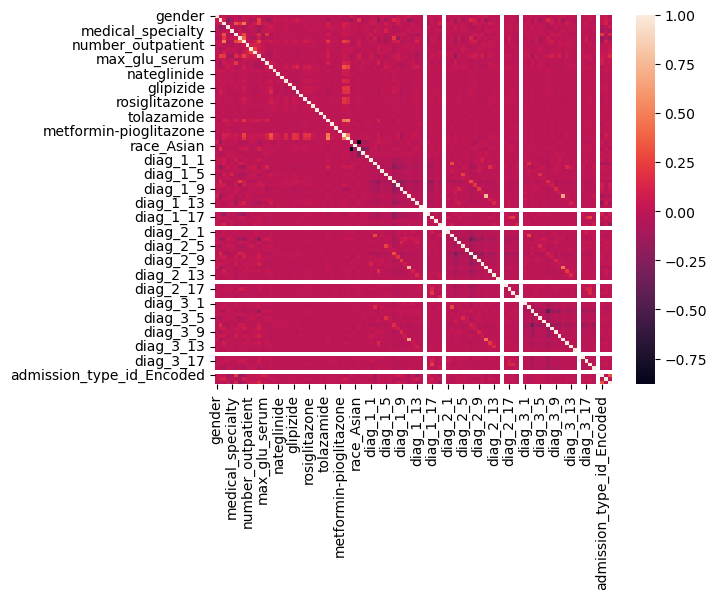

In [ ]:
corr = df_encoded.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

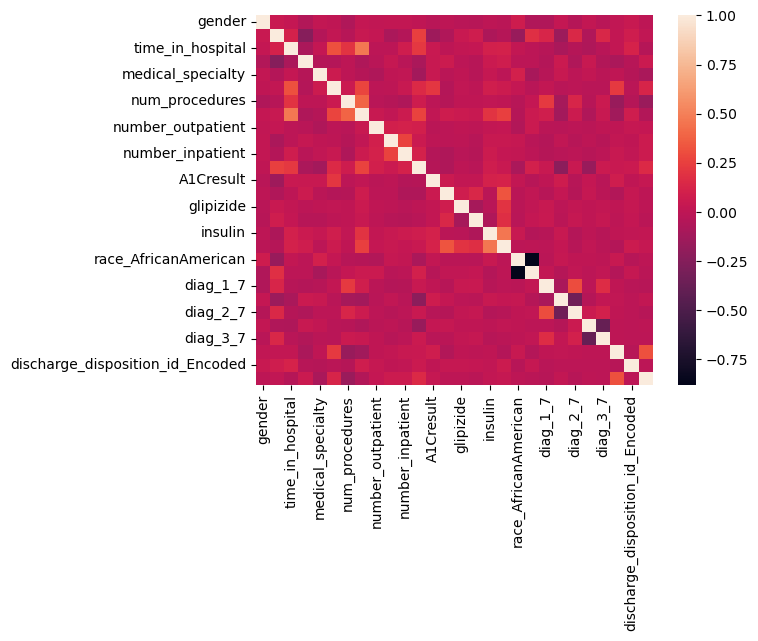

In [ ]:
corr = df_encoded_selected.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

Feature Selction

In [384]:
def naive_bayes_score(train, label, test, test_label):
    nb = RandomForestClassifier()
    nb.fit(train, label)
    y_nb = nb.predict(test)
    mse = np.mean((test_label - y_nb) ** 2)
    accuracy = accuracy_score(y_nb,test_label)

    return mse, accuracy

Naive Bayes for demstionality reduction result evaluation, This algorithm is very fast and works well with high-dimensional data. It assumes independence between the features, which may or may not hold after dimensionality reduction. According to the covr graph, mostly independent.

In [ ]:
rf_fs_score, accuracy = naive_bayes_score(df_encoded_selected,y_readmitted,df_test_encoded_selected,y_test_readmitted)
print(f"RF Feature Selection mse score is {rf_fs_score}, accuracy is {accuracy}.")

RF Feature Selection mse score is 0.6845279983914748, accuracy is 0.5621795516236051.


In [ ]:
pca = PCA(n_components=0.95)  # Keep 95% of the variance
pca_result = pca.fit_transform(df_encoded)
test_pca_result = pca.fit_transform(df_test_encoded)


In [ ]:
pca_score = naive_bayes_score(pca_result,y_readmitted,test_pca_result,y_test_readmitted)
print(f"PCA mse score is {pca_score}")

PCA mse score is (0.7288629737609329, 0.5280989242987836)


In [ ]:
non_dr_score = naive_bayes_score(df_encoded,y_readmitted,df_test_encoded,y_test_readmitted)
print(f"Full param mse score is {non_dr_score}")

Full param mse score is (2.4271639690358904, 0.12817935055795718)


In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=250)
tsne_result = tsne.fit_transform(df_encoded)

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=250)
tsne_test_result = tsne.fit_transform(df_test_encoded)

In [ ]:
tsne_score = naive_bayes_score(tsne_result,y_readmitted,tsne_test_result,y_test_readmitted)
print(f"tsne mse score is {tsne_score}")

tsne mse score is (0.7914949230923897, 0.537549009751684)


UMAP

Supervised DualWayUmap
1. Add test to embedding space
2. Add supervised
2. dual-way supervised for high dem linking
3. mahalanobis_euclidean distance


In [ ]:
import umap

Baseline

In [ ]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
umap_result = umap_model.fit_transform(df_encoded)
umap_test_result = umap_model.fit_transform(df_test_encoded)
umap_score,accuracy = naive_bayes_score(umap_result,y_readmitted,umap_test_result,y_test_readmitted)
print(f"umpa mse score is {umap_score}, accuracy is {accuracy}")

umpa mse score is 0.7914949230923897, accuracy is 0.537549009751684


test embedding

In [ ]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
umap_result = umap_model.fit_transform(df_encoded)
umap_test_result = umap_model.transform(df_test_encoded)
umpa_score = naive_bayes_score(umap_result,y_readmitted,umap_test_result,y_test_readmitted)
print(f"umpa mse score is {umpa_score}")

umpa mse score is (0.7914949230923897, 0.537549009751684)


Add supervising

In [ ]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
umap_result = umap_model.fit_transform(X=df_encoded,y =y_readmitted)
umap_test_result = umap_model.transform(df_test_encoded)
umap_score,accuracy = naive_bayes_score(umap_result,y_readmitted,umap_test_result,y_test_readmitted)
print(f"umpa mse score is {umap_score}, accuracy is {accuracy}")

umpa mse score is 0.7692771689956771, accuracy is 0.5380516738715191


In [ ]:
from umap.umap_ import *
from umap.utils import (
    ts,
    csr_unique
)

from warnings import warn
from sklearn.utils import check_random_state, check_array
from sklearn.metrics import pairwise_distances
try:
    import joblib
except ImportError:
    from sklearn.externals import joblib
import numpy as np
from scipy.sparse import tril as sparse_tril, triu as sparse_triu
import numba
import umap.distances as dist
from pynndescent.distances import named_distances as pynn_named_distances
from pynndescent.sparse import sparse_named_distances as pynn_sparse_named_distances

_mock_identity = np.eye(2, dtype=np.float64)
#
@numba.njit()
def mahalanobis_euclidean(x, y, vinv=_mock_identity):
    result = 0.0

    diff = np.empty(x.shape[0], dtype=np.float32)

    for i in range(x.shape[0]):
        diff[i] = x[i] - y[i]

    for i in range(x.shape[0]):
        tmp = 0.0
        for j in range(x.shape[0]):
            tmp += vinv[i, j] * diff[j]
        result += tmp * diff[i]
    e_result = 0.0
    for i in range(x.shape[0]):
        e_result += (x[i] - y[i]) ** 2

    return np.sqrt(result) + np.sqrt(e_result)

dist.mahalanobis = mahalanobis_euclidean

class DualWayUmap(UMAP):
    def concate_label(self,X,y):
        X["readmitted"] = y
        return X
    def fit(self, X, y=None, force_all_finite=True):
        """Fit X into an embedded space.

        Optionally use y for supervised dimension reduction.

        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            If the metric is 'precomputed' X must be a square distance
            matrix. Otherwise it contains a sample per row. If the method
            is 'exact', X may be a sparse matrix of type 'csr', 'csc'
            or 'coo'.

        y : array, shape (n_samples)
            A target array for supervised dimension reduction. How this is
            handled is determined by parameters UMAP was instantiated with.
            The relevant attributes are ``target_metric`` and
            ``target_metric_kwds``.

        force_all_finite : Whether to raise an error on np.inf, np.nan, pd.NA in array.
            The possibilities are: - True: Force all values of array to be finite.
                                   - False: accepts np.inf, np.nan, pd.NA in array.
                                   - 'allow-nan': accepts only np.nan and pd.NA values in array.
                                     Values cannot be infinite.
        """
        X = self.concate_label(X,y)

        X = check_array(X, dtype=np.float32, accept_sparse="csr", order="C", force_all_finite=force_all_finite)
        self._raw_data = X

        # Handle all the optional arguments, setting default
        if self.a is None or self.b is None:
            self._a, self._b = find_ab_params(self.spread, self.min_dist)
        else:
            self._a = self.a
            self._b = self.b

        if isinstance(self.init, np.ndarray):
            init = check_array(self.init, dtype=np.float32, accept_sparse=False, force_all_finite=force_all_finite)
        else:
            init = self.init

        self._initial_alpha = self.learning_rate

        self.knn_indices = self.precomputed_knn[0]
        self.knn_dists = self.precomputed_knn[1]
        # #848: allow precomputed knn to not have a search index
        if len(self.precomputed_knn) == 2:
            self.knn_search_index = None
        else:
            self.knn_search_index = self.precomputed_knn[2]

        self._validate_parameters()

        if self.verbose:
            print(str(self))

        self._original_n_threads = numba.get_num_threads()
        if self.n_jobs > 0 and self.n_jobs is not None:
            numba.set_num_threads(self.n_jobs)

        # Check if we should unique the data
        # We've already ensured that we aren't in the precomputed case
        if self.unique:
            # check if the matrix is dense
            if self._sparse_data:
                # Call a sparse unique function
                index, inverse, counts = csr_unique(X)
            else:
                index, inverse, counts = np.unique(
                    X,
                    return_index=True,
                    return_inverse=True,
                    return_counts=True,
                    axis=0,
                )[1:4]
            if self.verbose:
                print(
                    "Unique=True -> Number of data points reduced from ",
                    X.shape[0],
                    " to ",
                    X[index].shape[0],
                )
                most_common = np.argmax(counts)
                print(
                    "Most common duplicate is",
                    index[most_common],
                    " with a count of ",
                    counts[most_common],
                )
            # We'll expose an inverse map when unique=True for users to map from our internal structures to their data
            self._unique_inverse_ = inverse
        # If we aren't asking for unique use the full index.
        # This will save special cases later.
        else:
            index = list(range(X.shape[0]))
            inverse = list(range(X.shape[0]))

        # Error check n_neighbors based on data size
        if X[index].shape[0] <= self.n_neighbors:
            if X[index].shape[0] == 1:
                self.embedding_ = np.zeros(
                    (1, self.n_components)
                )  # needed to sklearn comparability
                return self

            warn(
                "n_neighbors is larger than the dataset size; truncating to "
                "X.shape[0] - 1"
            )
            self._n_neighbors = X[index].shape[0] - 1
            if self.densmap:
                self._densmap_kwds["n_neighbors"] = self._n_neighbors
        else:
            self._n_neighbors = self.n_neighbors

        # Note: unless it causes issues for setting 'index', could move this to
        # initial sparsity check above
        if self._sparse_data and not X.has_sorted_indices:
            X.sort_indices()

        random_state = check_random_state(self.random_state)

        if self.verbose:
            print(ts(), "Construct fuzzy simplicial set")

        if self.metric == "precomputed" and self._sparse_data:
            # For sparse precomputed distance matrices, we just argsort the rows to find
            # nearest neighbors. To make this easier, we expect matrices that are
            # symmetrical (so we can find neighbors by looking at rows in isolation,
            # rather than also having to consider that sample's column too).
            # print("Computing KNNs for sparse precomputed distances...")
            if sparse_tril(X).getnnz() != sparse_triu(X).getnnz():
                raise ValueError(
                    "Sparse precomputed distance matrices should be symmetrical!"
                )
            if not np.all(X.diagonal() == 0):
                raise ValueError("Non-zero distances from samples to themselves!")
            if self.knn_dists is None:
                self._knn_indices = np.zeros(
                    (X.shape[0], self.n_neighbors), dtype=int
                )
                self._knn_dists = np.zeros(self._knn_indices.shape, dtype=float)
                for row_id in range(X.shape[0]):
                    # Find KNNs row-by-row
                    row_data = X[row_id].data
                    row_indices = X[row_id].indices
                    if len(row_data) < self._n_neighbors:
                        raise ValueError(
                            "Some rows contain fewer than n_neighbors distances!"
                        )
                    row_nn_data_indices = np.argsort(row_data)[: self._n_neighbors]
                    self._knn_indices[row_id] = row_indices[row_nn_data_indices]
                    self._knn_dists[row_id] = row_data[row_nn_data_indices]
            else:
                self._knn_indices = self.knn_indices
                self._knn_dists = self.knn_dists
            # Disconnect any vertices farther apart than _disconnection_distance
            disconnected_index = self._knn_dists >= self._disconnection_distance
            self._knn_indices[disconnected_index] = -1
            self._knn_dists[disconnected_index] = np.inf
            edges_removed = disconnected_index.sum()

            (
                self.graph_,
                self._sigmas,
                self._rhos,
                self.graph_dists_,
            ) = fuzzy_simplicial_set(
                X[index],
                self.n_neighbors,
                random_state,
                "precomputed",
                self._metric_kwds,
                self._knn_indices,
                self._knn_dists,
                self.angular_rp_forest,
                self.set_op_mix_ratio,
                self.local_connectivity,
                True,
                self.verbose,
                self.densmap or self.output_dens,
            )
            # Report the number of vertices with degree 0 in our our umap.graph_
            # This ensures that they were properly disconnected.
            vertices_disconnected = np.sum(
                np.array(self.graph_.sum(axis=1)).flatten() == 0
            )
            raise_disconnected_warning(
                edges_removed,
                vertices_disconnected,
                self._disconnection_distance,
                self._raw_data.shape[0],
                verbose=self.verbose,
            )
        # Handle small cases efficiently by computing all distances
        elif X[index].shape[0] < 4096 and not self.force_approximation_algorithm:
            self._small_data = True
            try:
                # sklearn pairwise_distances fails for callable metric on sparse data
                _m = self.metric if self._sparse_data else self._input_distance_func
                dmat = pairwise_distances(X[index], metric=_m, **self._metric_kwds)
            except (ValueError, TypeError) as e:
                # metric is numba.jit'd or not supported by sklearn,
                # fallback to pairwise special

                if self._sparse_data:
                    # Get a fresh metric since we are casting to dense
                    if not callable(self.metric):
                        _m = dist.named_distances[self.metric]
                        dmat = dist.pairwise_special_metric(
                            X[index].toarray(),
                            metric=_m,
                            kwds=self._metric_kwds,
                            force_all_finite=force_all_finite
                        )
                    else:
                        dmat = dist.pairwise_special_metric(
                            X[index],
                            metric=self._input_distance_func,
                            kwds=self._metric_kwds,
                            force_all_finite=force_all_finite
                        )
                else:
                    dmat = dist.pairwise_special_metric(
                        X[index],
                        metric=self._input_distance_func,
                        kwds=self._metric_kwds,
                        force_all_finite=force_all_finite
                    )
            # set any values greater than disconnection_distance to be np.inf.
            # This will have no effect when _disconnection_distance is not set since it defaults to np.inf.
            edges_removed = np.sum(dmat >= self._disconnection_distance)
            dmat[dmat >= self._disconnection_distance] = np.inf
            (
                self.graph_,
                self._sigmas,
                self._rhos,
                self.graph_dists_,
            ) = fuzzy_simplicial_set(
                dmat,
                self._n_neighbors,
                random_state,
                "precomputed",
                self._metric_kwds,
                None,
                None,
                self.angular_rp_forest,
                self.set_op_mix_ratio,
                self.local_connectivity,
                True,
                self.verbose,
                self.densmap or self.output_dens,
            )
            # Report the number of vertices with degree 0 in our umap.graph_
            # This ensures that they were properly disconnected.
            vertices_disconnected = np.sum(
                np.array(self.graph_.sum(axis=1)).flatten() == 0
            )
            raise_disconnected_warning(
                edges_removed,
                vertices_disconnected,
                self._disconnection_distance,
                self._raw_data.shape[0],
                verbose=self.verbose,
            )
        else:
            # Standard case
            self._small_data = False
            # Standard case
            if self._sparse_data and self.metric in pynn_sparse_named_distances:
                nn_metric = self.metric
            elif not self._sparse_data and self.metric in pynn_named_distances:
                nn_metric = self.metric
            else:
                nn_metric = self._input_distance_func
            if self.knn_dists is None:
                (
                    self._knn_indices,
                    self._knn_dists,
                    self._knn_search_index,
                ) = nearest_neighbors(
                    X[index],
                    self._n_neighbors,
                    nn_metric,
                    self._metric_kwds,
                    self.angular_rp_forest,
                    random_state,
                    self.low_memory,
                    use_pynndescent=True,
                    n_jobs=self.n_jobs,
                    verbose=self.verbose,
                )
            else:
                self._knn_indices = self.knn_indices
                self._knn_dists = self.knn_dists
                self._knn_search_index = self.knn_search_index
            # Disconnect any vertices farther apart than _disconnection_distance
            disconnected_index = self._knn_dists >= self._disconnection_distance
            self._knn_indices[disconnected_index] = -1
            self._knn_dists[disconnected_index] = np.inf
            edges_removed = disconnected_index.sum()

            (
                self.graph_,
                self._sigmas,
                self._rhos,
                self.graph_dists_,
            ) = fuzzy_simplicial_set(
                X[index],
                self.n_neighbors,
                random_state,
                nn_metric,
                self._metric_kwds,
                self._knn_indices,
                self._knn_dists,
                self.angular_rp_forest,
                self.set_op_mix_ratio,
                self.local_connectivity,
                True,
                self.verbose,
                self.densmap or self.output_dens,
            )
            # Report the number of vertices with degree 0 in our umap.graph_
            # This ensures that they were properly disconnected.
            vertices_disconnected = np.sum(
                np.array(self.graph_.sum(axis=1)).flatten() == 0
            )
            raise_disconnected_warning(
                edges_removed,
                vertices_disconnected,
                self._disconnection_distance,
                self._raw_data.shape[0],
                verbose=self.verbose,
            )

        # Currently not checking if any duplicate points have differing labels
        # Might be worth throwing a warning...
        if y is not None:
            len_X = len(X) if not self._sparse_data else X.shape[0]
            if len_X != len(y):
                raise ValueError(
                    "Length of x = {len_x}, length of y = {len_y}, while it must be equal.".format(
                        len_x=len_X, len_y=len(y)
                    )
                )
            if self.target_metric == "string":
                y_ = y[index]
            else:
                y_ = check_array(y, ensure_2d=False, force_all_finite=force_all_finite)[index]
            if self.target_metric == "categorical":
                if self.target_weight < 1.0:
                    far_dist = 2.5 * (1.0 / (1.0 - self.target_weight))
                else:
                    far_dist = 1.0e12
                self.graph_ = discrete_metric_simplicial_set_intersection(
                    self.graph_, y_, far_dist=far_dist
                )
            elif self.target_metric in dist.DISCRETE_METRICS:
                if self.target_weight < 1.0:
                    scale = 2.5 * (1.0 / (1.0 - self.target_weight))
                else:
                    scale = 1.0e12
                # self.graph_ = discrete_metric_simplicial_set_intersection(
                #     self.graph_,
                #     y_,
                #     metric=self.target_metric,
                #     metric_kws=self.target_metric_kwds,
                #     metric_scale=scale
                # )

                metric_kws = dist.get_discrete_params(y_, self.target_metric)

                self.graph_ = discrete_metric_simplicial_set_intersection(
                    self.graph_,
                    y_,
                    metric=self.target_metric,
                    metric_kws=metric_kws,
                    metric_scale=scale,
                )
            else:
                if len(y_.shape) == 1:
                    y_ = y_.reshape(-1, 1)
                if self.target_n_neighbors == -1:
                    target_n_neighbors = self._n_neighbors
                else:
                    target_n_neighbors = self.target_n_neighbors

                # Handle the small case as precomputed as before
                if y.shape[0] < 4096:
                    try:
                        ydmat = pairwise_distances(
                            y_, metric=self.target_metric, **self._target_metric_kwds
                        )
                    except (TypeError, ValueError):
                        ydmat = dist.pairwise_special_metric(
                            y_,
                            metric=self.target_metric,
                            kwds=self._target_metric_kwds,
                            force_all_finite=force_all_finite
                        )

                    (target_graph, target_sigmas, target_rhos,) = fuzzy_simplicial_set(
                        ydmat,
                        target_n_neighbors,
                        random_state,
                        "precomputed",
                        self._target_metric_kwds,
                        None,
                        None,
                        False,
                        1.0,
                        1.0,
                        False,
                    )
                else:
                    # Standard case
                    (target_graph, target_sigmas, target_rhos,) = fuzzy_simplicial_set(
                        y_,
                        target_n_neighbors,
                        random_state,
                        self.target_metric,
                        self._target_metric_kwds,
                        None,
                        None,
                        False,
                        1.0,
                        1.0,
                        False,
                    )
                # product = self.graph_.multiply(target_graph)
                # # self.graph_ = 0.99 * product + 0.01 * (self.graph_ +
                # #                                        target_graph -
                # #                                        product)
                # self.graph_ = product
                self.graph_ = general_simplicial_set_intersection(
                    self.graph_, target_graph, self.target_weight
                )
                self.graph_ = reset_local_connectivity(self.graph_)
            self._supervised = True
        else:
            self._supervised = False

        if self.densmap or self.output_dens:
            self._densmap_kwds["graph_dists"] = self.graph_dists_

        if self.verbose:
            print(ts(), "Construct embedding")

        if self.transform_mode == "embedding":
            epochs = (
                self.n_epochs_list if self.n_epochs_list is not None else self.n_epochs
            )
            self.embedding_, aux_data = self._fit_embed_data(
                self._raw_data[index],
                epochs,
                init,
                random_state,  # JH why raw data?
            )

            if self.n_epochs_list is not None:
                if "embedding_list" not in aux_data:
                    raise KeyError(
                        "No list of embedding were found in 'aux_data'. "
                        "It is likely the layout optimization function "
                        "doesn't support the list of int for 'n_epochs'."
                    )
                else:
                    self.embedding_list_ = [
                        e[inverse] for e in aux_data["embedding_list"]
                    ]

            # Assign any points that are fully disconnected from our manifold(s) to have embedding
            # coordinates of np.nan.  These will be filtered by our plotting functions automatically.
            # They also prevent users from being deceived a distance query to one of these points.
            # Might be worth moving this into simplicial_set_embedding or _fit_embed_data
            disconnected_vertices = np.array(self.graph_.sum(axis=1)).flatten() == 0
            if len(disconnected_vertices) > 0:
                self.embedding_[disconnected_vertices] = np.full(
                    self.n_components, np.nan
                )

            self.embedding_ = self.embedding_[inverse]
            if self.output_dens:
                self.rad_orig_ = aux_data["rad_orig"][inverse]
                self.rad_emb_ = aux_data["rad_emb"][inverse]

        if self.verbose:
            print(ts() + " Finished embedding")

        numba.set_num_threads(self._original_n_threads)
        self._input_hash = joblib.hash(self._raw_data)

        return self


In [ ]:
umap_model = DualWayUmap(n_neighbors=5, min_dist=0.3, n_components=2) #euclidean distance
umap_result = umap_model.fit_transform(X=df_encoded,y =y_readmitted)
umap_test_result = umap_model.transform(df_test_encoded)

umap_score,accuracy = naive_bayes_score(umap_result,y_readmitted,umap_test_result,y_test_readmitted)
print(f"umap mse score is {umap_score},accuracy is {accuracy}")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


umap mse score is 0.7373005854321358,accuracy is 0.4992460038202473


In [ ]:
y_readmitted = pd.read_csv('y_readmitted.csv').to_numpy()
y_test_readmitted = pd.read_csv('y_test_readmitted.csv').to_numpy()
df_encoded = pd.read_csv('encoded_train.csv')
df_test_encoded = pd.read_csv('encoded_test.csv')
umap.distances.mahalanobis = mahalanobis_euclidean

umap_model = DualWayUmap(n_neighbors=5, min_dist=0.3, n_components=2,metric = "mahalanobis")

umap_result = umap_model.fit_transform(X=df_encoded,y =y_readmitted)

umap_test_result = umap_model.transform(df_test_encoded)
umap_score,accuracy = naive_bayes_score(umap_result,y_readmitted,umap_test_result,y_test_readmitted)
print(f"umap mse score is {umap_score},accuracy is {accuracy}")


umap mse score is 0.762738644301073,accuracy is 0.5069870312657082


PCA and t-sne

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=250)
pca_tsne_trian_result = tsne.fit_transform(pca_result)

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=250)
pca_tsne_result = tsne.fit_transform(test_pca_result)

In [ ]:
pca_tsne_score = naive_bayes_score(pca_tsne_trian_result,y_readmitted,pca_tsne_result,y_test_readmitted)
print(f"pca-tsne mse score is {pca_tsne_score}")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pca-tsne mse score is (0.7914949230923897, 0.537549009751684)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
y_readmitted = pd.read_csv('y_readmitted.csv').to_numpy()
y_test_readmitted = pd.read_csv('y_test_readmitted.csv').to_numpy()
df_encoded = pd.read_csv('encoded_train.csv')
df_test_encoded = pd.read_csv('encoded_test.csv')

In [ ]:
# Number of features in your dataset
n_features = len(df_encoded.columns) 


input_layer = Input(shape=(n_features,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)


bottleneck = Dense(10, activation='relu')(encoder)  

# Define the decoder (mirror the encoder)
decoder = Dense(32, activation='relu')(bottleneck)
decoder = Dense(64, activation='relu')(decoder)

# Output layer
output_layer = Dense(n_features, activation='sigmoid')(decoder) 

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
df_encoded = df_encoded.astype('float32')
df_test_encoded = df_test_encoded.astype('float32')
autoencoder.fit(df_encoded, df_encoded,  # The target is the input data itself
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(df_test_encoded, df_test_encoded))

Epoch 1/100
699/699 [==============================] - 2s 3ms/step - loss: 0.8226 - val_loss: 0.8176
Epoch 2/100
699/699 [==============================] - 1s 2ms/step - loss: 0.8223 - val_loss: 0.8177
Epoch 3/100
699/699 [==============================] - 2s 2ms/step - loss: 0.8221 - val_loss: 0.8173
Epoch 4/100
699/699 [==============================] - 1s 2ms/step - loss: 0.8220 - val_loss: 0.8172
Epoch 5/100
699/699 [==============================] - 1s 2ms/step - loss: 0.8218 - val_loss: 0.8171
Epoch 6/100
699/699 [==============================] - 1s 2ms/step - loss: 0.8217 - val_loss: 0.8169
Epoch 7/100
699/699 [==============================] - 1s 2ms/step - loss: 0.8215 - val_loss: 0.8166
Epoch 8/100
699/699 [==============================] - 1s 2ms/step - loss: 0.8213 - val_loss: 0.8167
Epoch 9/100
699/699 [==============================] - 1s 2ms/step - loss: 0.8212 - val_loss: 0.8162
Epoch 10/100
699/699 [==============================] - 1s 2ms/step - loss: 0.8211 - val_lo

In [ ]:
encoder_model = Model(inputs=input_layer, outputs=bottleneck)
reconstructed_data = autoencoder.predict(df_encoded)
reconstructed_test_data = autoencoder.predict(df_test_encoded)

311/311 [==============================] - 0s 1ms/step


In [ ]:
AE_score, accuracy = naive_bayes_score(reconstructed_data,y_readmitted,reconstructed_test_data,y_test_readmitted)
print(f"AE mse score is {AE_score}, AE accuracy score is {accuracy}")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AE mse score is 1.0338340707509124, AE accuracy score is 0.502060922891324


# Model Building
We will build five models: 
1. Hist Gradient Boosting Classifier
2. Support Vector Machines
3. K Nearest Neighbors
4. Random Forest Classifier
5. Multilayer Perceptron


At the first step we will impor the model evauluation methods

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

## load data:

In [395]:

X = df_encoded_selected
y = y_readmitted
X_test = df_test_encoded_selected
y_test = y_test_readmitted



## Hist Gradient Boosting Classifier

In [ ]:
HGB_classifier = HistGradientBoostingClassifier(max_iter=100)
HGB_classifier.fit(X, y)


/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier()

In [ ]:
y_pred = HGB_classifier.predict(X_test)
y_pred_prob = HGB_classifier.predict_proba(X_test)

HGB_accuracy = accuracy_score(y_test,y_pred)
HGB_F1 = f1_score(y_test, y_pred,average = 'weighted' )
HGB_Precision = precision_score(y_test, y_pred,average = 'weighted')
HGB_Recall = recall_score(y_test, y_pred,average = 'weighted')
HGB_AUC = roc_auc_score(y_test, y_pred_prob, multi_class= "ovr")

print("accuracy:", HGB_accuracy)
print("F1 Score:", HGB_F1)
print("Precision:", HGB_Precision)
print("Recall:", HGB_Recall)
print("AUC score:", HGB_AUC)

accuracy: 0.5899266110385041
F1 Score: 0.5483826522390691
Precision: 0.5594465678301046
Recall: 0.5899266110385041
AUC score: 0.6712319995556612


## Support Vector Machines(SVM)

In [ ]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(X,y)

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [ ]:
y_pred = SVM_model.predict(X_test)
#y_pred_prob = SVM_model.predict_proba(X_test)
SVM_accuracy = accuracy_score(y_test,y_pred)
SVM_F1 = f1_score(y_test, y_pred,average = 'weighted' )
SVM_Precision = precision_score(y_test, y_pred,average = 'weighted')
SVM_Recall = recall_score(y_test, y_pred,average = 'weighted')
SVM_AUC = roc_auc_score(y_test, y_pred_prob, multi_class= "ovr")

print("accuracy:", SVM_accuracy)
print("F1 Score:", SVM_F1)
print("Precision:", SVM_Precision)
print("Recall:", SVM_Recall)
print("AUC score:", SVM_AUC)
#print("AUC score:", roc_auc_score(y_test, y_pred_prob, multi_class= "ovr"))

accuracy: 0.5742434904996482
F1 Score: 0.5041967854269118
Precision: 0.545367145806212
Recall: 0.5742434904996482
AUC score: 0.6712319995556612


## K Nearest Neighbors(KNN)

In [ ]:
k = 3  # 选择 K 值
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X,y)


/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn_classifier.predict(X_test)
y_pred_prob = knn_classifier.predict_proba(X_test)

knn_accuracy = accuracy_score(y_test,y_pred)
knn_F1 = f1_score(y_test, y_pred,average = 'weighted' )
knn_Precision = precision_score(y_test, y_pred,average = 'weighted')
knn_Recall = recall_score(y_test, y_pred,average = 'weighted')
knn_AUC = roc_auc_score(y_test, y_pred_prob, multi_class= "ovr")

print("accuracy:", knn_accuracy)
print("F1 Score:", knn_F1)
print("Precision:", knn_Precision)
print("Recall:", knn_Recall)
print("AUC score:", knn_AUC)

accuracy: 0.509902483160752
F1 Score: 0.48268550260725707
Precision: 0.47342860417192295
Recall: 0.509902483160752
AUC score: 0.5529472672941621


## Random Forest Classifier

In [ ]:

RF_classifier = RandomForestClassifier(n_estimators=100)
RF_classifier.fit(X, y)


/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [ ]:
y_pred = RF_classifier.predict(X_test)
y_pred_prob = RF_classifier.predict_proba(X_test)

RF_accuracy = accuracy_score(y_test,y_pred)
RF_F1 = f1_score(y_test, y_pred,average = 'weighted' )
RF_Precision = precision_score(y_test, y_pred,average = 'weighted')
RF_Recall = recall_score(y_test, y_pred,average = 'weighted')
RF_AUC = roc_auc_score(y_test, y_pred_prob, multi_class= "ovr")

print("accuracy:", RF_accuracy)
print("F1 Score:", RF_F1)
print("Precision:", RF_Precision)
print("Recall:", RF_Recall)
print("AUC score:", RF_AUC)

accuracy: 0.5762541469789887
F1 Score: 0.5342404298574568
Precision: 0.5553829022415167
Recall: 0.5762541469789887
AUC score: 0.646050772126041


## Multilayer Perceptron(MLP)

In [ ]:
# the code for Nerual Network
class MLP(nn.Module):
    '''
    MLP class for predicting pixel values based on positions.
    '''
    def __init__(self, input_dimension, nb_layers, embedding_dimension, output_dimension):
        super(MLP, self).__init__()

        # Create a list to hold all layers
        layers = []

        # First layer
        layers.append(nn.Linear(input_dimension, embedding_dimension))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(nb_layers - 2):
            layers.append(nn.Linear(embedding_dimension, embedding_dimension))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(embedding_dimension, embedding_dimension))
        layers.append(nn.Sigmoid())
        layers.append(nn.Linear(embedding_dimension, output_dimension))

        # Combine all layers
        self.layers = nn.Sequential(*layers)

    def forward(self, input):
        # Pass the input through all layers
        prediction = self.layers(input)

        return prediction

model = MLP(len(X.columns),5,32,3)

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def loss_function(predict,target):
    loss_func = nn.BCEWithLogitsLoss()
    return loss_func(predict,target) 

X = pd.DataFrame(X)
X_tensor = torch.tensor(X.values.astype(float), dtype=torch.float32)
df_y = pd.DataFrame(y)
Y_dl = pd.get_dummies(df_y[0])

y_tensor = torch.tensor(Y_dl.values.astype(float), dtype=torch.float32).squeeze(1)

target_task_data = CustomDataset(X_tensor,y_tensor)  # Load your target task data
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = 'cpu'
model.to(device)
model.train()

for _ in range(200):
    for batch in tqdm(DataLoader(target_task_data, batch_size=1000, shuffle=True)):
        inputs, targets = batch
        optimizer.zero_grad()
        predictions = nn.functional.softmax(model(inputs),dim = 1)
        loss = loss_function(predictions, targets)
        loss.backward()
        optimizer.step()

if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/diabets_prediction.pth")


  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:00<00:00, 209.07it/s]


In [ ]:
X_test = pd.DataFrame(X_test)
X_test_tensor = torch.tensor(X_test.values.astype(float),dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(float), dtype=torch.float32)
test_loader = TensorDataset(X_test_tensor, y_test_tensor)

model.eval()
total = 0
correct = 0
y_pred = np.array([])
with torch.no_grad():
    for data in test_loader:  # 假设 test_loader 是测试数据的 DataLoader
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data,0)
    
        y_pred = np.append(y_pred,predicted.item())
        

y_pred.reshape(1,-1)

MLP_accuracy = accuracy_score(y_test,y_pred)
MLP_F1 = f1_score(y_test, y_pred,average = 'weighted' )
MLP_Precision = precision_score(y_test, y_pred,average = 'weighted')
MLP_Recall = recall_score(y_test, y_pred,average = 'weighted')

print("accuracy:", MLP_accuracy)
print("F1 Score:", MLP_F1)
print("Precision:", MLP_Precision)
print("Recall:", MLP_Recall)

accuracy: 0.5767568110988238
F1 Score: 0.5226224977812971
Precision: 0.4981793310409367
Recall: 0.5767568110988238


/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Convolutional Neural Network(CNN)

In [ ]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

X_tensor = torch.tensor(X.values.astype(float), dtype=torch.float32)
y_tensor = torch.tensor(y.values.astype(int), dtype=torch.long).squeeze(1)

X_test_tensor = torch.tensor(X_test.values.astype(float), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.astype(int), dtype=torch.long)

train_dataset = TensorDataset(X_tensor[:89344, :], y_tensor[:89344])
test_dataset = TensorDataset(X_test_tensor[:9920, :], y_test_tensor[:9920])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1)  # 输入通道数改为 31
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(7, 128)  # 根据池化结果调整线性层输入尺寸
        self.fc2 = nn.Linear(128, 3)  # 假设是三分类问题

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # 展平
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()

for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(loss)

tensor(0.9439, grad_fn=<NllLossBackward0>)
tensor(1.0032, grad_fn=<NllLossBackward0>)
tensor(0.9725, grad_fn=<NllLossBackward0>)
tensor(0.8949, grad_fn=<NllLossBackward0>)
tensor(0.9114, grad_fn=<NllLossBackward0>)
tensor(0.9089, grad_fn=<NllLossBackward0>)
tensor(0.9394, grad_fn=<NllLossBackward0>)
tensor(0.9627, grad_fn=<NllLossBackward0>)
tensor(1.0077, grad_fn=<NllLossBackward0>)
tensor(0.9570, grad_fn=<NllLossBackward0>)
tensor(1.1064, grad_fn=<NllLossBackward0>)
tensor(0.9381, grad_fn=<NllLossBackward0>)
tensor(0.9816, grad_fn=<NllLossBackward0>)
tensor(0.8635, grad_fn=<NllLossBackward0>)
tensor(0.9527, grad_fn=<NllLossBackward0>)
tensor(0.9700, grad_fn=<NllLossBackward0>)
tensor(0.8872, grad_fn=<NllLossBackward0>)
tensor(0.9301, grad_fn=<NllLossBackward0>)
tensor(0.8910, grad_fn=<NllLossBackward0>)
tensor(0.8938, grad_fn=<NllLossBackward0>)
tensor(1.0148, grad_fn=<NllLossBackward0>)
tensor(0.8428, grad_fn=<NllLossBackward0>)
tensor(1.0720, grad_fn=<NllLossBackward0>)
tensor(0.97

In [ ]:

model.eval()
total = 0
correct = 0
y_pred = np.array([])
y_test_l= torch.tensor([])
with torch.no_grad():
    for data in test_loader: 
        inputs, labels = data
        outputs = model(inputs)
        predicted = outputs.data
        split_tensors = torch.split(predicted, 1)
        for i, sub_tensor in enumerate(split_tensors):
            _,res = torch.max(sub_tensor, dim=1)
            y_pred = np.append(y_pred,res.item())
        y_test_l = torch.cat((y_test_l, labels), dim=0)

y_pred = y_pred.reshape(-1,1)
y_test_l = y_test_l.numpy().reshape(-1,1)



CNN_accuracy = accuracy_score(y_test_l,y_pred)
CNN_F1 = f1_score(y_test_l, y_pred,average = 'weighted' )
CNN_Precision = precision_score(y_test_l, y_pred,average = 'weighted')
CNN_Recall = recall_score(y_test_l, y_pred,average = 'weighted')

print("accuracy:", CNN_accuracy)
print("F1 Score:", CNN_F1)
print("Precision:", CNN_Precision)
print("Recall:", CNN_Recall)

accuracy: 0.5388104838709677
F1 Score: 0.3812777825386859
Precision: 0.5138659693617277
Recall: 0.5388104838709677


/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


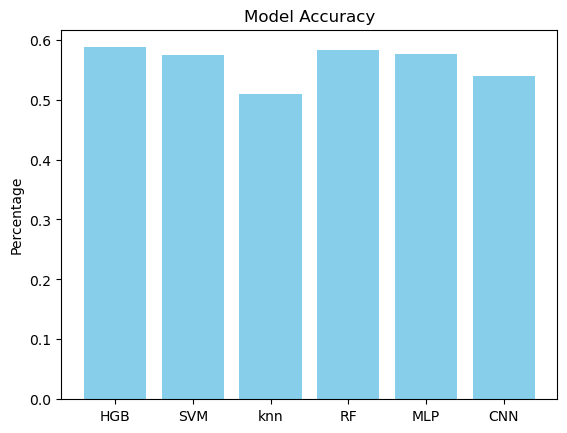

In [ ]:
data = np.array([HGB_accuracy,SVM_accuracy,knn_accuracy,RF_accuracy,MLP_accuracy,CNN_accuracy])
model_names = ["HGB","SVM","knn","RF","MLP","CNN"]

plt.bar(model_names, data, color='skyblue')
plt.title('Model Accuracy')
plt.ylabel('Percentage')
plt.show()

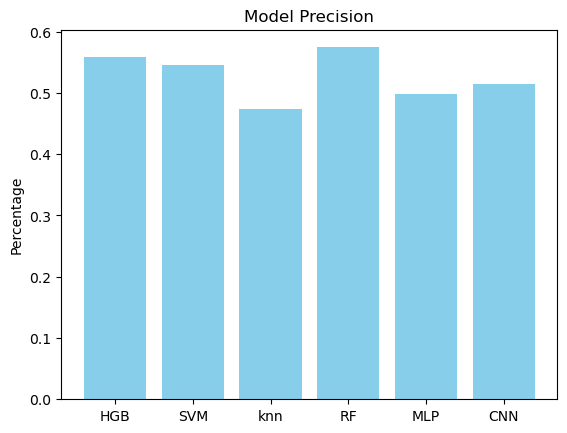

In [ ]:
data = np.array([HGB_Precision,SVM_Precision,knn_Precision,RF_Precision,MLP_Precision,CNN_Precision])

plt.bar(model_names, data, color='skyblue')
plt.title('Model Precision')
plt.ylabel('Percentage')
plt.show()

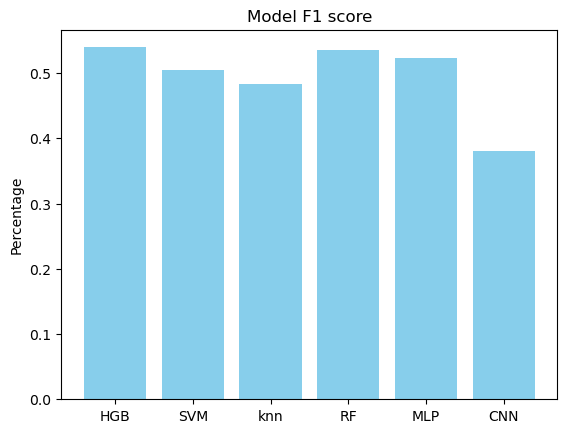

In [ ]:
data = np.array([HGB_F1,SVM_F1,knn_F1,RF_F1,MLP_F1,CNN_F1])

plt.bar(model_names, data, color='skyblue')
plt.title('Model F1 score')
plt.ylabel('Percentage')
plt.show()

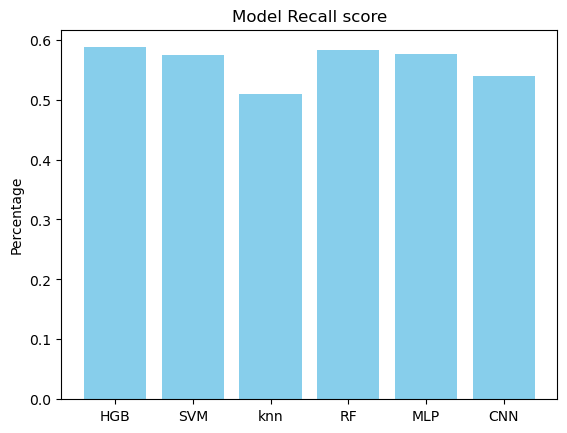

In [ ]:
data = np.array([HGB_Recall,SVM_Recall,knn_Recall,RF_Recall,MLP_Recall,CNN_Recall])
plt.bar(model_names, data, color='skyblue')
plt.title('Model Recall score')
plt.ylabel('Percentage')
plt.show()

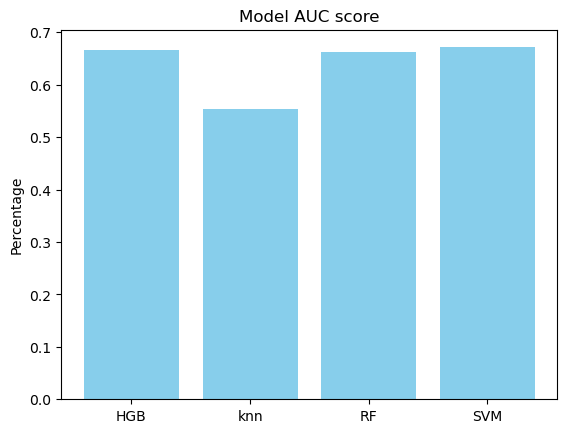

In [ ]:
data = np.array([HGB_AUC,knn_AUC,RF_AUC,SVM_AUC])
model_names = ["HGB","knn","RF","SVM"]
plt.bar(model_names, data, color='skyblue')
plt.title('Model AUC score')
plt.ylabel('Percentage')
plt.show()

## Model Optmisation

### Hist Gradient Boosting Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV


model = HistGradientBoostingClassifier()

param_grid = {
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

In [397]:
HGB_optmised_classifier = HistGradientBoostingClassifier(learning_rate= 0.1, max_depth=3,max_iter=100)
HGB_optmised_classifier.fit(X,y)

y_pred = HGB_optmised_classifier.predict(X_test)
y_pred_prob = HGB_optmised_classifier.predict_proba(X_test)

HGB_accuracy = accuracy_score(y_test,y_pred)
HGB_F1 = f1_score(y_test, y_pred,average = 'weighted' )
HGB_Precision = precision_score(y_test, y_pred,average = 'weighted')
HGB_Recall = recall_score(y_test, y_pred,average = 'weighted')
HGB_AUC = roc_auc_score(y_test, y_pred_prob, multi_class= "ovr")

print("accuracy:", HGB_accuracy)
print("F1 Score:", HGB_F1)
print("Precision:", HGB_Precision)
print("Recall:", HGB_Recall)
print("AUC score:", HGB_AUC)

accuracy: 0.5913340705740424
F1 Score: 0.5449936527266239
Precision: 0.5621205237958914
Recall: 0.5913340705740424
AUC score: 0.6675638466236299


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
paramsgrid  = {'n_estimators': [100,200,400],
               'max_depth': [25, 30,50,100],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 5, 10]
 }

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)
 
rf_random.fit(X, y)

print(rf_random.best_estimator_)

In [ ]:
RF_optmised_classifier = RandomForestClassifier(max_depth=100, min_samples_split=10, n_estimators=400)
RF_optmised_classifier.fit(X,y)

y_pred = RF_optmised_classifier.predict(X_test)
y_pred_prob = RF_optmised_classifier.predict_proba(X_test)

RF_accuracy = accuracy_score(y_test,y_pred)
RF_F1 = f1_score(y_test, y_pred,average = 'weighted' )
RF_Precision = precision_score(y_test, y_pred,average = 'weighted')
RF_Recall = recall_score(y_test, y_pred,average = 'weighted')
RF_AUC = roc_auc_score(y_test, y_pred_prob, multi_class= "ovr")

print("accuracy:", RF_accuracy)
print("F1 Score:", RF_F1)
print("Precision:", RF_Precision)
print("Recall:", RF_Recall)
print("AUC score:", RF_AUC)

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


accuracy: 0.5819845179451091
F1 Score: 0.5357505507897714
Precision: 0.5745805651486684
Recall: 0.5819845179451091
AUC score: 0.6613177948258965


## Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(HGB_optmised_classifier, X, y, cv=5)


print("Accuracy scores for each fold:", scores)


print("Mean accuracy:", scores.mean())

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A 

Accuracy scores for each fold: [0.56912662 0.57273948 0.56412265 0.587735   0.58986124]
Mean accuracy: 0.5767169972402018


In [ ]:

scores = cross_val_score(RF_optmised_classifier, X, y, cv=5)


print("Accuracy scores for each fold:", scores)


print("Mean accuracy:", scores.mean())

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column

Accuracy scores for each fold: [0.56828736 0.56960609 0.56373098 0.58185989 0.58202775]
Mean accuracy: 0.5731024139731331
